In [1]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ESKO\PYWORK\NHITS


In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [3]:
cutoff_date = '2022-01-31' ## len = 65
test_period = 11  ## 예측 기간 (월)
corr_rate = 0.7 ## Lag corr rate
hist_corr_rate = 0.9 ## Lag corr rate
future_variable_limit = 2
hist_variable_limit = 5

## <원 data set>

In [4]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

df_tgt = df.iloc[:,3:]
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [5]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 15.5 s
Wall time: 28.5 s


#### 해당 기간에서의 lag corr best

In [6]:
raw_y_set_shifted_merged

,date,y,y_11_,y2,y2_11_,Baltic Dry Index (BDI),Baltic Dry Index (BDI)_11_,Howe Robinson Container Index,Howe Robinson Container Index_11_,Shanghai Containerized Freight Index (SCFI),...,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_Open_11_,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_High_11_,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Low_11_,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_11_,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_11_
0,2016-01-31,20.177268,NaN,-0.237734,NaN,-1.302468,NaN,-0.644064,NaN,-0.195705,...,-0.915916,NaN,-0.911882,NaN,-0.921663,NaN,-0.909069,NaN,-0.909069,NaN
1,2016-02-29,23.306868,NaN,-0.054803,NaN,-1.396112,NaN,-0.645288,NaN,-0.182527,...,-0.910118,NaN,-0.915569,NaN,-0.908508,NaN,-0.916207,NaN,-0.916207,NaN
2,2016-03-31,25.223010,NaN,0.133909,NaN,-1.305967,NaN,-0.644523,NaN,-0.362815,...,-0.833402,NaN,-0.834459,NaN,-0.834589,NaN,-0.834453,NaN,-0.834453,NaN
3,2016-04-30,25.308243,NaN,0.173425,NaN,-1.041598,NaN,-0.648195,NaN,-0.472294,...,-0.691659,NaN,-0.695181,NaN,-0.693237,NaN,-0.700107,NaN,-0.700107,NaN
4,2016-05-31,24.875099,NaN,0.107095,NaN,-1.026945,NaN,-0.645747,NaN,-0.487834,...,-0.497700,NaN,-0.494779,NaN,-0.496022,NaN,-0.493870,NaN,-0.493870,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2021-09-30,19.083333,6.750000,-0.280700,-0.802596,3.299182,0.165344,1.991462,-0.398120,0.100634,...,1.124191,-0.836410,1.123562,-0.841054,1.129411,-0.831269,1.129772,-0.834654,1.129772,-0.834654
69,2021-10-31,22.750000,6.750000,-0.096964,-0.802596,3.926870,-0.365877,1.998856,-0.274918,0.187008,...,1.020054,-0.685379,1.006143,-0.671095,1.008416,-0.678276,1.008169,-0.670957,1.008169,-0.670957
70,2021-11-30,28.170455,6.750000,0.164625,-0.802596,1.521353,-0.291234,1.794166,-0.201334,0.556798,...,1.240984,-0.383040,1.248657,-0.378218,1.253894,-0.375241,1.257281,-0.374061,1.257281,-0.374061
71,2021-12-31,33.043478,6.940476,0.286579,-0.802596,1.582281,0.196868,1.839908,-0.158958,1.084157,...,1.185124,-0.058113,1.187299,-0.040440,1.189690,-0.063073,1.197156,-0.043393,1.197156,-0.043393


In [7]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}_')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}_", "") for word in futr_list]

# if 'li2co395_am_kg' in futr_list:
#     futr_list = [w.replace('li2co395_am_kg', 'li2co3_995_am_kg') for w in futr_list]
# raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

# if 'y2' in futr_list:
#     (futr_list).remove('y2')
# if 'li2co395_am_kg' in futr_list:
#     (futr_list).remove('li2co395_am_kg')
# if 'li2co3_995_am_kg' in futr_list:
#     (futr_list).remove('li2co3_995_am_kg')
# if 'mn_mb_kg' in futr_list:
#     (futr_list).remove('mn_mb_kg')
# if 'al_lme_kg' in futr_list:
#     (futr_list).remove('al_lme_kg')

In [8]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

,y
중국 산업생산_11_,0.700753
CLI_KOR_11_,0.826592


In [9]:
futr_list

['중국 산업생산', 'CLI_KOR']

#### 해당 기간에서의 corr best

In [10]:
hist_variable_limit

5

In [11]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= hist_corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_list = hist_var_list[:hist_variable_limit]
hist_list

[]

In [12]:
hist_var_corr_filtered_y_only

,y


#### static DF

In [13]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [14]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [15]:
# len(df.loc[df.ds<'2021-06-30'])

In [16]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [17]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [18]:
futr_list

['중국 산업생산', 'CLI_KOR']

In [19]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
futr_df

,ds,unique_id,중국 산업생산,CLI_KOR
0,2022-02-28,A,1.404522,1.608332
1,2022-03-31,A,0.662184,1.773524
2,2022-04-30,A,0.489548,1.842799
3,2022-05-31,A,0.403230,1.804233
4,2022-06-30,A,0.075220,1.667671
5,2022-07-31,A,-0.114680,1.452713
6,2022-08-31,A,-0.494480,1.181848
7,2022-09-30,A,-0.425426,0.897073
8,2022-10-31,A,-0.373635,0.635059
9,2022-11-30,A,-0.287317,0.399509


#### No 변수

In [20]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [21]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [22]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [23]:
Y_test_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
73,2022-02-28,A,56.425000,1.270279,0.406105,2.294724,1.435042,1.467862,0.798730,1.945680,...,2.197789,2.207543,2.190755,2.181831,2.058747,1.168835,1.174279,1.163390,1.167415,1.167415
74,2022-03-31,A,71.086957,2.126927,1.148209,2.612162,1.241856,1.831557,1.195636,2.269497,...,2.026895,2.013125,2.037362,2.013198,1.906047,1.471655,1.468981,1.476677,1.477051,1.477051
75,2022-04-30,A,75.804348,2.687810,0.860751,2.556884,1.425830,2.242691,1.391677,2.722841,...,2.170896,2.152358,2.152352,2.132638,2.410643,2.259286,2.271036,2.255625,2.261700,2.261700
76,2022-05-31,A,74.295455,2.621695,1.713126,2.501607,1.892086,2.385006,1.329234,3.305713,...,1.814178,1.807191,1.810962,1.808275,2.410643,2.106495,2.106820,2.111163,2.116623,2.116623
77,2022-06-30,A,73.000000,2.389233,1.060177,2.515599,2.230336,2.471976,1.161657,3.111422,...,1.310465,1.314768,1.273957,1.284862,2.410643,1.628496,1.623594,1.607981,1.608344,1.608344
78,2022-07-31,A,73.000000,2.389233,0.691597,2.439292,2.526593,2.377100,0.921668,2.852368,...,1.464141,1.460176,1.481963,1.473009,2.410643,1.436494,1.434052,1.439497,1.441548,1.441548
79,2022-08-31,A,73.000000,2.420773,-0.092744,2.119559,2.773368,2.369193,0.793818,2.593314,...,2.219001,2.233095,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215
80,2022-09-30,A,74.047619,2.507937,-0.004062,1.188816,3.024986,2.250597,0.750690,1.621862,...,2.107414,2.092161,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251
81,2022-10-31,A,77.673913,2.664680,0.381286,0.204375,3.036207,1.784119,0.691518,1.427572,...,2.352264,2.359441,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120
82,2022-11-30,A,80.818182,2.828879,-0.226024,-0.008117,3.004479,1.784119,1.005474,1.621862,...,2.433279,2.443712,2.455263,2.452607,2.303940,2.830058,2.817705,2.816214,2.795982,2.795982


In [24]:
if len(Y_test_df) > 0:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    
    
if cutoff_date <= '2021-12-31':
    flexible = None
else:
    flexible = futr_df

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          NBEATSx(h=horizon, input_size=5 * horizon,
                # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                gpus=1,
                scaler_type='robust',
                stat_exog_list = None,
                # hist_exog_list = hist_list,
                # futr_exog_list = None,  
                futr_exog_list = flexible,
                learning_rate=1e-4,
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                batch_size=512,
                random_seed=42,
                n_blocks=[1, 1, 1],
                # val_check_steps=10,
                # early_stop_patience_steps=2
                max_steps=10
               ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                # futr_exog_list = None,
                # hist_exog_list = hist_list,
                futr_exog_list = flexible,
                n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                n_freq_downsample=[24, 12, 1],
                scaler_type = 'robust',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=512,
                random_seed=42,
                max_epochs=10
               ),
          # LSTM(h=horizon, input_size=5 * horizon,
          #        # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #        scaler_type='robust',
          #        encoder_n_layers=2,
          #        encoder_hidden_size=128,
          #        context_size=10,
          #        decoder_hidden_size=128,
          #        decoder_layers=2,
          #        gpus = 1,
          #        futr_exog_list=futr_df,
          #        hist_exog_list=hist_list,
          #        stat_exog_list=None,
          #        max_steps=10
          #        ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=horizon, 
          #     input_size=5 * horizon,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     # hidden_size=128,
          #     # n_head=4, 
          #     # attn_dropout=0.0,
          #     hist_exog_list=hist_list,
          #     dropout=0.1,
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = flexible,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True,
          #     max_steps=10
          #    ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df).reset_index()

Epoch 0:  50%|███████████████               | 1/2 [00:01<00:01,  1.92s/it, loss=1.4, v_num=2247, train_loss_step=1.400]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██▌  | 1/2 [00:00<00:00,  7.09it/s, loss=1.35, v_num=2247, train_loss_step=1.300, train_loss_epoch=1.400]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██▌  | 1/2 [00:00<00:00,  6.69it/s, loss=1.31, v_num=2247, train_loss_step=1.240, train_loss_epoch=1.300]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██▌  | 1/2 [00:00<00:00,  7.11it/s, loss=1.27, v_num=2247, train_loss_step=1.150, train_loss_epoch=1.240]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|██▌  | 1/2 [00:00<00:00,  6.98it/s, loss=1.23, v_num=2247, train_loss_step=1.080, train_loss_epoch=1.150]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|██▌  | 1/2 [00:00<00:00,  7.09it/s, loss=1.19, v_num=2247, train_loss_step=0.986, train_loss_epoch=1.080]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|██▌  | 1/2 [00:00<00:00,  7.08it/s, loss=1.16, v_num=2247, train_loss_step=0.930

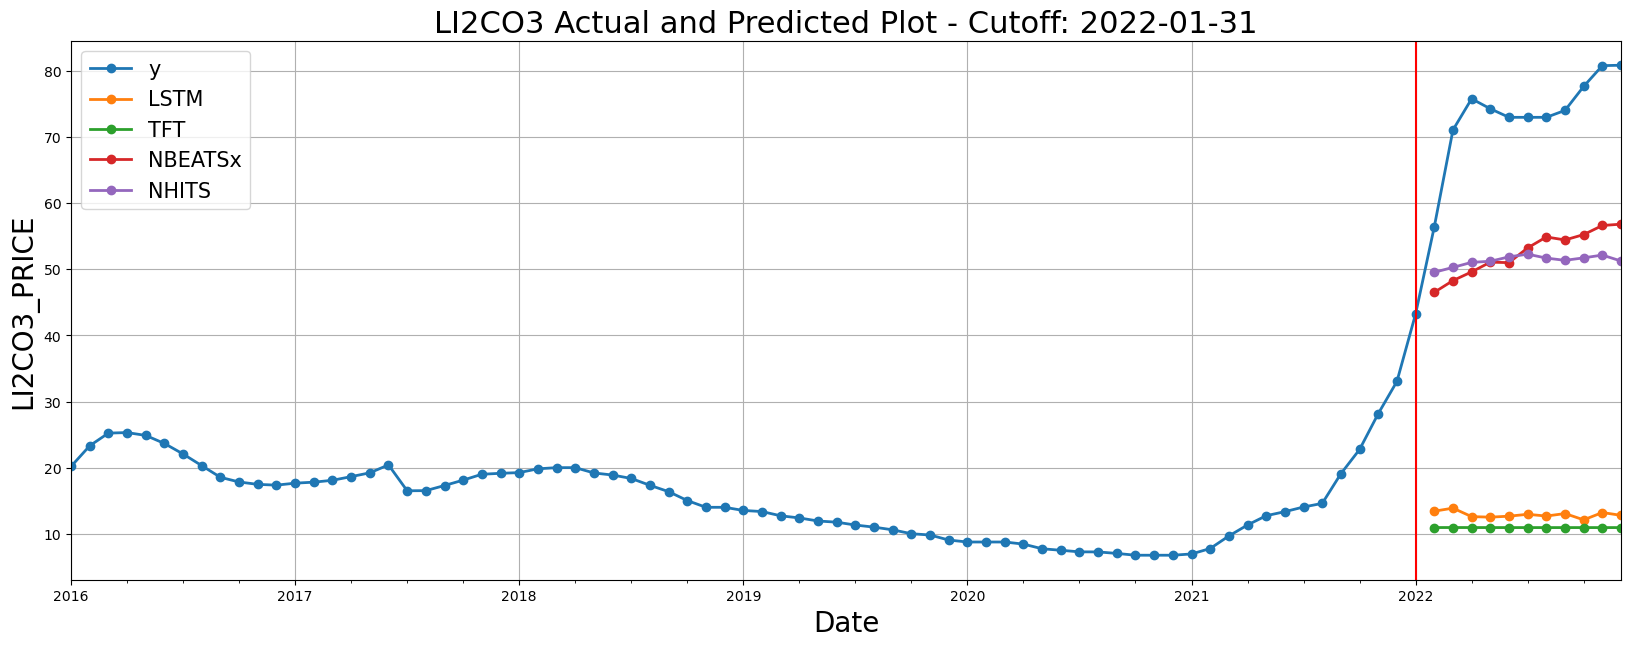

In [25]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y','LSTM','NBEATSx', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [26]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)

In [27]:
Y_train_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
0,2016-01-31,A,20.177268,-0.237734,-1.302468,-0.644064,-0.195705,-0.461301,-0.468886,0.391356,...,-0.831670,-0.828692,-0.830830,-0.827825,-0.397665,-0.915916,-0.911882,-0.921663,-0.909069,-0.909069
1,2016-02-29,A,23.306868,-0.054803,-1.396112,-0.645288,-0.182527,-0.532459,-0.733272,0.138779,...,-0.748690,-0.746808,-0.752678,-0.750469,-0.397665,-0.910118,-0.915569,-0.908508,-0.916207,-0.916207
2,2016-03-31,A,25.223010,0.133909,-1.305967,-0.644523,-0.362815,-0.532459,-0.012903,0.099921,...,-0.731866,-0.730402,-0.733675,-0.731680,-0.397665,-0.833402,-0.834459,-0.834589,-0.834453,-0.834453
3,2016-04-30,A,25.308243,0.173425,-1.041598,-0.648195,-0.472294,-0.524553,-0.083130,-0.003701,...,-0.520540,-0.501075,-0.525438,-0.509230,-0.397665,-0.691659,-0.695181,-0.693237,-0.700107,-0.700107
4,2016-05-31,A,24.875099,0.107095,-1.026945,-0.645747,-0.487834,-0.445488,0.514051,-0.074941,...,-0.375846,-0.367456,-0.391346,-0.377609,-0.397665,-0.497700,-0.494779,-0.496022,-0.493870,-0.493870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2021-09-30,A,19.083333,-0.280700,3.299182,1.991462,0.100634,0.953946,1.372534,-0.295136,...,1.205264,1.204125,1.199434,1.197162,0.611440,1.124191,1.123562,1.129411,1.129772,1.129772
69,2021-10-31,A,22.750000,-0.096964,3.926870,1.998856,0.187008,0.613970,1.257820,-0.042559,...,1.077746,1.073697,1.076272,1.073636,0.565137,1.020054,1.006143,1.008416,1.008169,1.008169
70,2021-11-30,A,28.170455,0.164625,1.521353,1.794166,0.556798,0.811631,1.318295,0.391356,...,1.453358,1.456465,1.463497,1.467292,1.031930,1.240984,1.248657,1.253894,1.257281,1.257281
71,2021-12-31,A,33.043478,0.286579,1.582281,1.839908,1.084157,0.969759,1.115623,0.520883,...,1.766336,1.775690,1.776023,1.790538,1.704423,1.185124,1.187299,1.189690,1.197156,1.197156
